In [103]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from svgpathtools import svg2paths


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/code/side/genpen/scratch/some_svg_file.svg'

# try 1

In [2]:
svgpath = '/mnt/c/code/side/plotter_images/u2_visor_portrait_trace.svg'
doc = vpype.read_svg(svgpath, quantization=0.1, simplify=True, crop=True, parallel=True)

In [38]:
paths, attributes = svg2paths(svgpath)

In [71]:
def complex_to_xy(point):
    return point.real, point.imag

In [75]:
def svgLine_to_LineString(line):
    return LineString([
        complex_to_xy(line.start),
        complex_to_xy(line.end),
    ])

In [133]:
page_x_inches: float = 11 # inches
page_y_inches: float = 14 # inches
border:float = 20.

buffer_style = 3

In [134]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-border, py-border)
xmin, ymin, xmax, ymax = drawbox.bounds

In [135]:
mls = so.linemerge(MultiLineString([svgLine_to_LineString(line) for line in paths[1]]))
fills = MultiPolygon([Polygon(ls) for ls in mls])

lines = so.linemerge(MultiLineString([svgLine_to_LineString(line) for line in paths[0]]))

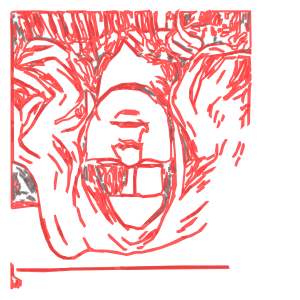

In [136]:
sg.GeometryCollection([fills, lines])

In [109]:
def consolidate_polygons2(polys):
    '''For if polygons are inside each other '''
    consolidated_polys = []
    for p0 in polys:
        other_polys = [p for p in polys if p != p0]
        p0_contains = []
        p0_is_within = []
        for p1 in other_polys:
            if p0.contains(p1):
                p0_contains.append(p1)
            elif p0.within(p1):
                p0_is_within.append(p1)
        
        new_p = Polygon(p0)
        if not any(p0_is_within):
            new_p = gp.robust_difference(p0, so.unary_union(p0_contains))
            consolidated_polys.append(new_p)
    return consolidated_polys

In [140]:
mp = MultiPolygon([p for p in fills if p.area > 0])

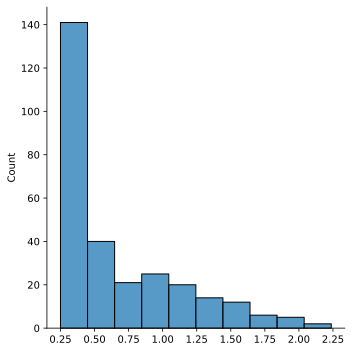

In [141]:
sns.displot([np.log10(p.area) for p in fills])

In [142]:
small_polys = []
large_polys = []
thresh = 0.1
for p in mp:
    if p.area > thresh:
        large_polys.append(p.buffer(1e-6))
    else:
        small_polys.append(p)

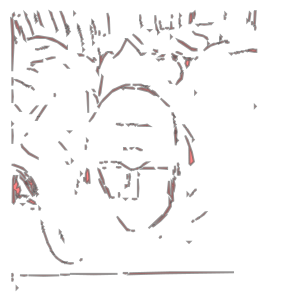

In [143]:
gp.merge_Polygons(large_polys)

In [144]:
lps = list(gp.merge_Polygons(large_polys))

In [145]:
areas = [p.area for p in lps]

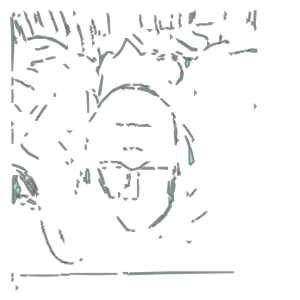

In [146]:
sort_lps = [lps[i] for i in np.argsort(areas)]
consolidated_ps = consolidate_polygons2(sort_lps)
MultiPolygon(consolidated_ps)

In [164]:
all_polys = MultiPolygon(lps + small_polys)

In [165]:
scaled_geos = gp.make_like(sg.GeometryCollection([lines, all_polys]), drawbox)

In [166]:
traces = scaled_geos[0]
polys = scaled_geos[1]

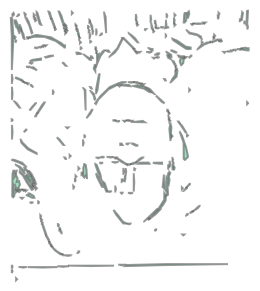

In [188]:

sapb = polys.buffer(1e-3)
sapb

In [189]:
stp = gp.ScaleTransPrms(n_iters=100, d_buffer=-0.2, d_translate_factor=0.3, angles=np.radians(-90))
# stp.d_buffers *= gp.gaussian_random_walk(n=stp.d_buffers.shape[0], step_std=10)

In [194]:
all_fills = []
for p in sapb:
    fills = gp.scale_trans(p, **stp.prms)
    mfills = gp.merge_LineStrings([f.boundary for f in fills])
    all_fills.append(mfills)

In [195]:
fill_layer = gp.merge_LineStrings(all_fills)

In [196]:
min_path_length = 5
filter_fill_layer = MultiLineString([f for f in fill_layer if f.length>min_path_length])

In [198]:
sk = vsketch.Vsketch()
sk.size(page_format)
sk.scale('1mm')
sk.penWidth('0.25mm')
sk.geometry(traces)
sk.geometry(filter_fill_layer)
sk.geometry(traces.buffer(1, cap_style=2, join_style=2).boundary)
sk.display(color_mode='None')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2020-12-12T14:20:45.626777 
 
 
 
 
 
 <polygon points="75.9474,148.4605 79.8178,152.3309 83.6882,156.2013 84.683,161.3346 85.6779,166.4679 89.5455,167.7557 93.413,169.0436 91.5881,161.0358 89.7632,153.0279 95.537,159.8025 101.3108,166.5771 99.6967,173.0082 98.0826,179.4393 102.1417,179.4393 106.2008,179.4393 108.0228,176.4913 109.8447,173.5434 106.4595,165.3708 103.0743,157.1981 100.1681,157.1981 97.2619,157.1981 99.0982,155.3617 100.9346,153.5254 106.512,158.5728 112.0893,163.6202 112.0893,171.2656 112.0893,178.9109 99.4328,186.3281 86.7763,193.7453 84.2994,200.2601 81.8225,206.7748 81.9342,221.1954 82.0459,235.616 78.9967,238.6653 75.9474,241.7145 76.2245,204.3216 76.5017,166.9286 78.7276,173.879 80.9535,180.8293 81.0352,168.3187 81.1169,155.808 78.7276,161.3683 76.3382,166.9286 76.1428,157.6946"/>
 <polygon points="76.2747,1193.854 76.807,824.4945 77.3394,455.135 78.7285,453.9347 80.1176,452.7343 118.8154,457.6229 157.5131,462.5116 167.2389,460.9333 176.9647,459.355 175.1958,463.9646 173.427,468.5742 175.7266,468.5742 178.0262,468.5742 181.297,447.0281 184.5679,425.482 188.8287,403.6923 193.0896,381.9025 200.2417,360.6 207.3938,339.2975 216.5052,319.2977 225.6165,299.2978 238.4701,286.4442 251.3238,273.5905 263.0257,268.2781 274.7277,262.9657 294.3025,262.9046 313.8772,262.8436 335.4395,276.4593 357.0017,290.0749 365.9073,291.688 374.8129,293.301 397.9954,290.9076 421.178,288.5143 425.7969,289.6061 430.4158,290.698 463.7775,285.0329 497.1392,279.3678 504.5746,277.7714 512.0099,276.1749 529.7735,280.6298 547.5371,285.0847 558.481,285.0847 569.425,285.0847 587.4949,288.8972 605.5648,292.7096 626.4159,298.7858 647.267,304.8619 673.6784,314.8361 700.0897,324.8103 716.5316,333.0192 732.9734,341.2281 744.901,344.8177 756.8286,348.4074 774.8007,358.458 792.7727,368.5085 800.8725,378.9243 808.9723,389.3401 811.3932,393.4628 813.814,397.5854 797.2639,380.9063 780.7139,364.2272 765.4231,357.017 750.1323,349.8069 736.6435,346.526 723.1547,343.2451 701.2183,332.2157 679.2818,321.1863 659.1042,313.2441 638.9266,305.3019 612.5152,299.0717 586.1038,292.8415 578.0436,290.3532 569.9833,287.8649 554.4123,287.7429 538.8414,287.6208 527.7208,283.6145 516.6002,279.6082 510.023,279.5663 503.4458,279.5245 490.562,283.567 477.6782,287.6095 455.4371,290.4063 433.1959,293.203 412.671,293.2613 392.1462,293.3196 382.1385,298.2377 372.1308,303.1557 362.856,319.8365 353.5812,336.5174 350.7011,339.2976 347.8211,342.0777 357.8418,321.9911 367.8625,301.9044 367.8625,300.5014 367.8625,299.0985 356.0469,293.1433 344.2313,287.1882 328.9405,277.8346 313.6497,268.4811 300.7732,266.7196 287.8967,264.9582 273.8878,269.6112 259.8788,274.2643 246.9898,285.6097 234.1007,296.9551 223.4884,318.1263 212.8762,339.2976 205.9676,358.7586 199.0591,378.2196 194.7327,397.6806 190.4062,417.1416 185.9234,444.943 181.4406,472.7445 175.8275,507.4962 170.2144,542.248 162.3926,558.9289 154.5709,575.6098 141.5153,593.2044 128.4596,610.799 109.8489,619.1215 91.2382,627.4441 87.068,629.6299 82.8978,631.8159 82.2873,742.72 81.6768,853.6242 85.0674,849.2862 88.4581,844.9482 99.0992,832.0558 109.7404,819.1634 111.9395,800.2519 114.1387,781.3404 114.5041,798.434 114.8694,815.5276 106.3675,831.7957 97.8655,848.0639 105.9424,838.4775 114.0193,828.8911 119.0777,836.6112 124.136,844.3312 141.7501,859.2742 159.3641,874.2173 169.4453,877.0009 179.5265,879.7844 190.088,874.3963 200.6496,869.0082 202.5393,863.0542 204.4291,857.1002 202.0464,855.3622 199.6638,853.6242 190.5753,835.5532 181.4867,817.4823 165.554,789.0999 149.6212,760.7175 132.9629,743.2275 116.3047,725.7375 115.3621,733.8003 114.4195,741.8631 117.5498,754.2946 120.6801,766.726 119.3675,768.0386 118.0549,769.3512 115.0876,758.6649 112.1203,747.9787 112.1047,740.244 112.0892,732.5093 108.19,723.1774 104.2909,713.8454 106.8853,701.6811 109.4797,689.5168 125.3802,676.7794 141.2807,664.042 163.023,652.7518 184.7654,641.4617 179.8465,646.897 174.9277,652.3323 158.1042,6

In [199]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0110_me_trace.svg'

sk.save(savepath)

vpype_commands = 'reloop linesimplify --tolerance 0.05mm linemerge --tolerance 0.3mm linesort'
vpype_str = f'vpype read -q 0.05mm {savepath} {vpype_commands} write {savepath}'

os.system(vpype_str)

0